In [103]:
"""
Python script for comparison of theoretical and simualtion velocities, then determination of behaviour for different 
cosmological parameters.
"""
from tqdm import tqdm
import time 
import numpy as np 
import math
import scipy.spatial as spatial
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.ndimage as sp

#open positions file
f=open('mbp_positions_063_M13_matched.txt', "r")
lines=f.readlines()

#create empty lists for relevant data 

mass = []
r_200 = []
x = []
y = []
z = []

# append data 
for k in lines:
        mass.append(k.split(  )[11])
        r_200.append(k.split(  )[13])
        x.append(k.split(  )[6])   
        y.append(k.split(  )[7]) 
        z.append(k.split(  )[8])
        
f.close()

#convert list to numpy array for with floats rather than strings 
mass_array = np.array(mass).astype(np.float)

#sort masses over 10^15 from array 
mass_15 = mass_array[mass_array > 1E+5]

#find maximum mass from sample
overdens = np.min(mass_15)
print(overdens)

r=30

# find index of selected mass in array 
result = np.where(mass_array == overdens)
print(result)

103994.7891
(array([19455], dtype=int64),)


In [104]:
#find origin coordinates
x_0 = x[19455]
y_0 = y[19455]
z_0 = z[19455]
r_vir = r_200[19455]


In [105]:
# read out data from selection file
f=open('radius_test.txt', "r")
lines=f.readlines()

x = []
y = []
z = []
v_x = []
v_y = []
v_z = []

for k in lines:
        x.append(k.split(  )[0])   
        y.append(k.split(  )[1]) 
        z.append(k.split(  )[2]) 
        v_x.append(k.split(  )[3])
        v_y.append(k.split(  )[4])
        v_z.append(k.split(  )[5])
        
f.close()

x_mass = np.array(x).astype(np.float)
y_mass = np.array(y).astype(np.float)
z_mass = np.array(z).astype(np.float)
v_x_mass = np.array(v_x).astype(np.float)
v_y_mass = np.array(v_y).astype(np.float)
v_z_mass = np.array(v_z).astype(np.float)
r_vir = np.array(r_vir).astype(np.float) 
print(x_0)

0.7316458130E+02


In [106]:
#Dot product to find component of velocity radial to halo centre
x_radial = x_mass - float(x_0)
y_radial = y_mass - float(y_0)
z_radial = z_mass - float(z_0)

radial_v = np.ones(len(x_mass))
for i in range(len(x_mass)):
    v_r = (v_x_mass[i]*x_radial[i] + v_y_mass[i]*y_radial[i] + v_z_mass[i]*z_radial[i])/np.sqrt(x_radial[i]**2 + y_radial[i]**2 + z_radial[i]**2)
    radial_v[i] *= v_r
    


In [107]:
#add hubble flow to velocities
h = 0.73
H_0 = 100 * h 
a_array = np.ones(len(x_mass))
for j in range(len(x_mass)):
    a = np.sqrt(((x_mass[j] - float(x_0))**2 + (y_mass[j] - float(y_0))**2 + (z_mass[j] - float(z_0))**2))
    a_array[j] *= a
  
v_total = np.ones(len(x_mass))
for i in range(len(x_mass)):
    v = radial_v[i] + (a_array[i]*H_0)
    v_total[i] *= v
    
print()

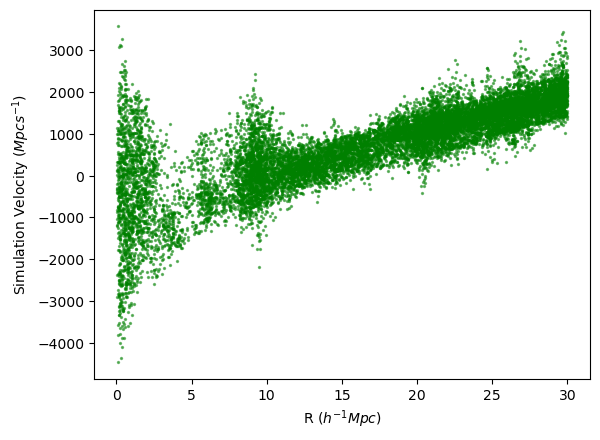

In [108]:
# plot simulation data curve 
fig, ax = plt.subplots()

ax.scatter(a_array, v_total, color = 'green', s = 2, alpha = 0.5)
#ax.set_ylim(-5000,8000)
#ax.set_xlim(-1, 31)
ax.set_xlabel('R $(h^{-1} Mpc)$')
ax.set_ylabel('Simulation Velocity $(Mpc s^{-1})$')
#plt.axhline(y=0, color ='black', alpha = 0.6)
plt.show()

In [8]:
#bin velocity curve
mask = a_array>5
hist, bin_edges = np.histogram(a_array, bins= 30)


In [9]:
# define constants       
h = 0.73
H_0 = 100 * h 
omega_m = 0.25
omega_lambda = 0.75
f = omega_m**(4/7) + (1 + omega_m/2)*(omega_lambda/70)
delta_c = 1.686
G = 4.301*10**-9
d_M =2.2* overdens *10**10



In [10]:
#calculate constants and velocities for theoretical curve
A = (f*delta_c)/3


def B_const(G, d_M, H_0, omega_m, r):
    B = (2*G*d_M)/((H_0**2)*omega_m*r**3)
    return B

def V_func(H_0, r, A, B, delta_c):
    V_r = H_0*r*(1 - A*((B+1)**(1/delta_c) - 1))
    return V_r

r_array = np.ones(len(x_mass))
    
B_const_array = np.ones(len(r_array), dtype=np.float64)
V_r_array = np.ones(len(r_array), dtype=np.float64)

for j in range(len(x_mass)):
    a = np.sqrt(((x_mass[j] - float(x_0))**2 + (y_mass[j] - float(y_0))**2 + (z_mass[j] - float(z_0))**2))
    r_array[j] *= a



for i in range(len(r_array)):
    B_const(G, d_M, H_0, omega_m, r_array[i])

    B_const_array[i] *= B_const(G, d_M, H_0, omega_m, r_array[i])


for k in range(len(a_array)): 
    V_func(H_0, r_array[k], A, B_const_array[k], delta_c)
    V_r_array[k] *= V_func(H_0, r_array[k], A, B_const_array[k], delta_c)

In [11]:
variance = np.ones(len(bin_edges))
vert = a_array[mask]
v_y_arr = np.ones(len(vert))

for k in range(len(vert)):
    vy = v_total[mask][k] - V_r_array[mask][k]
    v_y_arr[k] *= vy

for i in range(len(bin_edges)):
    bin_array = np.array([])
    for j in range(len(a_array)):
        if a_array[j] <= bin_edges[0]:
            bin_array = np.append(bin_array, v_total[j])
        if a_array[j] <= bin_edges[i] and a_array[j] >= bin_edges[i - 1]:
     
            bin_array = np.append(bin_array, v_total[j])
        
   
    c = np.var(bin_array)
       
    variance[i] *= c
    
    

In [12]:
# defining constants or parameter arrays
#h_range = np.arange(0.4, 1.0, 0.02) 
h_range= np.array([0.73])
omega_m = 0.25
omega_lambda = 0.75
f = omega_m**(4/7) + (1 + omega_m/2)*(omega_lambda/70)
delta_c = 1.686
G = 4.301*10**-9
#m_range = np.arange(1, 4, 0.1)
m_range = np.array([0.1, 0.15,0.2,0.25, 0.3,0.35,4.0])
omega_m = np.array([0.25])
cs_true = np.array([])
# loop over omega_m
for value in tqdm(omega_m):
    omega_m = value
    omega_lambda = 1-value
    f = omega_m**(4/7) + (1 + omega_m/2)*(omega_lambda/70)
    #loop over h 
    for value in tqdm(h_range):

        h_val = value
        H_0 = 100 * h_val
        
        #loop over delta_m value
        for val in tqdm(m_range):   
            m_val = val
            A = (f*delta_c)/3
            d_M = m_val* overdens *10**10

            def B_const(G, d_M, H_0, omega_m, r):
                B = (2*G*d_M)/((H_0**2)*omega_m*r**3)
                return B

            def V_func(H_0, r, A, B, delta_c):
                V_r = H_0*r*(1 - A*((B+1)**(1/delta_c) - 1))
                return V_r

            r_array = np.ones(len(x_mass))

            B_const_array = np.ones(len(r_array), dtype=np.float64)
            V_r_array = np.ones(len(r_array), dtype=np.float64)

            for j in range(len(x_mass)):
                a = np.sqrt(((x_mass[j] - float(x_0))**2 + (y_mass[j] - float(y_0))**2 + (z_mass[j] - float(z_0))**2))
                r_array[j] *= a



            for i in range(len(r_array)):
                B_const(G, d_M, H_0, omega_m, r_array[i])

                B_const_array[i] *= B_const(G, d_M, H_0, omega_m, r_array[i])


            for k in range(len(a_array)): 
                V_func(H_0, r_array[k], A, B_const_array[k], delta_c)
                V_r_array[k] *= V_func(H_0, r_array[k], A, B_const_array[k], delta_c)
            
            variance = np.ones(len(bin_edges))
            vert = a_array[mask]
            cs_bins = np.array([])

            v_y_arr = np.ones(len(vert))
            #determine differnece in bvelocity for each point assuming no x axis variation 
            for k in range(len(vert)):
                vy = v_total[mask][k] - V_r_array[mask][k]
                v_y_arr[k] *= vy
            # finding variance per bin
            for i in range(len(bin_edges)):

                bin_array = np.array([])
                for j in range(len(a_array)):
                    if a_array[j] <= bin_edges[0]:
                        bin_array = np.append(bin_array, v_total[j])
                    if a_array[j] <= bin_edges[i] and a_array[j] >= bin_edges[i - 1]:

                        bin_array = np.append(bin_array, v_total[j])


                c = np.var(bin_array)

                variance[i] *= c


                # calculatig chisquare value
                bin_array = np.array([])
                for j in range(len(vert)):
                    if vert[j] <= bin_edges[0]:
                        bin_array = np.append(bin_array, v_total[j])
                    if vert[j] <= bin_edges[i] and vert[j] >= bin_edges[i - 1]:
                        bin_array = np.append(bin_array, v_total[j])

                    cs_bin_array = np.ones(len(bin_array))
                    for q in range(len(bin_array)):
                        chisq = (v_y_arr[q]**2)/variance[i]

                        cs_bin_array[q] *= chisq 

                cs_bin = np.sum(cs_bin_array)

                cs_bins = np.append(cs_bins, cs_bin)
            cs_mass = np.sum(cs_bins)
            cs_true = np.append(cs_true, cs_mass)
            outfile = open('Chisq_values_halo_1.txt', 'a')
            outfile.write(str(cs_mass)+ "  " + str(m_val)+"  " + str(h_val)+ "  " + str(omega_m) + "\n" )
            outfile.close







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:29<00:00, 149.64s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:26<00:00, 146.91s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████

In [14]:
#write to chisquare file
outfile = open('Chisq_values_halo_1.txt', 'a')
outfile.write(str(cs_mass) + "  "  + str(h_val) + "\n" )
outfile.close

<function TextIOWrapper.close()>

In [22]:
len(a_array[mask])

12554